In [0]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
# Here specify the path to your directory
!ls "/content/gdrive/My Drive/DeepLearning" 
root_path = 'gdrive/My Drive/DeepLearning' 
path ='/content/gdrive/My Drive/DeepLearning'
os.chdir(path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
 BatchNormalisation.ipynb
 clip_figure1.PNG
 cnn_accuracies.png
 Comparison_activations.png
 Comparison_lrs.png
 data
'ffn_BN_accuracy_97.46_lr=0.005_20200419'
'ffn_BN_accuracy_97.55_lr=0.005_20200419'
'ffn_BN_accuracy_97.71_lr=0.005_20200419'
'ffn_NO_BN_accuracy_96.71_lr=0.005_20200419'
'ffn_NO_BN_accuracy_97.85_lr=0.005_20200419'
'ffn_NO_BN_accuracy_97.8_lr=0.005_20200419'
'ffn_NO_BN_accuracy_97.99_lr=0.005_20200419'
 figure1.PNG
 FromScratch.ipynb
 MNIST
 

In [0]:
import torch 
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

import time # to save the model with the date

torch.manual_seed(1) # important for reproducibility

Loading the train and test loaders with bacthes of 60 as in the paper.

In [0]:
transform = transforms.Compose( [transforms.ToTensor()] )                          
trainset = torchvision.datasets.MNIST(root=path, train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=60,     
                                          shuffle=True, num_workers=1)
testset = torchvision.datasets.MNIST(root=path, train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=60,
                                         shuffle=False, num_workers=1)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

The following two classes are inspired by section ... of the paper. 

In [0]:
# Batch Normalisation  
class Net_BN(nn.Module):
    def __init__(self, lr=0.2, momentum=0.9, choice_activation='sigmoid'):
        super(Net_BN, self).__init__()
        #layers
        self.fc1 = nn.Linear(28 * 28, 100) # first hidden layer
        self.bn1 = nn.BatchNorm1d(100) 
        self.fc2 = nn.Linear(100, 100) # second hidden layer
        self.bn2 = nn.BatchNorm1d(100)
        self.fc3 = nn.Linear(100, 100) # third hidden layer
        self.bn3 = nn.BatchNorm1d(100)                
        self.fc4 = nn.Linear(100, 10)  # output layer

        #hyperparameters      
        self.lr = lr
        self.momentum = momentum

        self.init_weights = self.fc1.weight.data # to print a typical weight initialisation

        # choice of activation function
        self.choice_activation = choice_activation

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=self.lr, momentum=self.momentum)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

        self.name = 'ffn_BN' # to save the model 

    def forward(self, x):
        x = x.to(self.device)
        x = torch.flatten(x, start_dim=1)
        x = self.nonlinearity(self.bn1(self.fc1(x)))
        x = self.nonlinearity(self.bn2(self.fc2(x)))
        x = self.bn3(self.fc3(x))     # dimension is (60, 100)

        self.activation = x[:, 0] # input to 0th sigmoid, tensor of size (60)
        self.activations = x # input to every sigmoid, size is (60, 100)
        x = self.nonlinearity(x)
        
        x = self.fc4(x)
        return x

    def nonlinearity(self, x):
        '''Selection of non-linear activation function '''
        if self.choice_activation == 'sigmoid':
          x = torch.sigmoid(x)
        elif self.choice_activation == 'tanh':
          x = torch.tanh(x)
        elif self.choice_activation == 'relu':
          x = F.relu(x)
        elif self.choice_activation == 'elu':
          x = F.elu(x)
        else:
          ValueError('Activation choice provided is incorrect or not implemented')

        return x



# Without Batch Normalisation 
class Net(nn.Module):
    def __init__(self, lr=0.2, momentum=0.9, choice_activation='sigmoid'):
        super(Net, self).__init__()
        # layers
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 10)

        # hyperparameters        
        self.lr = lr
        self.momentum = momentum

        # selection of activation function
        self.choice_activation = choice_activation

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=self.lr, momentum=self.momentum)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
        self.name = 'ffn_NO_BN'

    def forward(self, x):
        x = x.to(self.device)
        x = torch.flatten(x, start_dim=1)
        x = self.nonlinearity(self.fc1(x))
        x = self.nonlinearity(self.fc2(x))

        x = self.fc3(x)

        self.activation = x[:, 0] 
        self.activations = x
        x = self.nonlinearity(x)

        x = self.fc4(x)
        return x  

    def nonlinearity(self, x):
        '''Selection of non-linear activation function '''
        if self.choice_activation == 'sigmoid':
          x = torch.sigmoid(x)
        elif self.choice_activation == 'tanh':
          x = torch.tanh(x)
        elif self.choice_activation == 'relu':
          x = F.relu(x)
        elif self.choice_activation == 'elu':
          x = F.elu(x)
        else:
          ValueError('Activation choice provided is incorrect or not implemented')

        return x


This has the porpuse of proving that the weights are already initialized to small values by default. Therefore we did not implement a different initialisation procedure.

In [0]:
net_BN = Net_BN()
net    = Net()

# to show that the networks are initialized with small values by default
init_weights = net_BN.init_weights
print(init_weights)
print(torch.max(init_weights))
print(torch.min(init_weights))

The function *train* is used to avoid repetition of code. It works for both the network with and without bacth normalisation. By default loss is printed every 1000 minibatches.
It is very important to use the command *model.eval()* when the purpose is to test the model (even if toch.no_grad() is used). The reason is that it tells to *batch_norm* to operate in testing mode.

In [0]:
def train(model, tainloader, testloader, epochs = 50, LOSS_EVERY=1000, TEST_EVERY=1000):
  '''This function train the model on the data provided by trainloader.
   Test on testloader every TEST_EVERY. 
  '''
  print('...Training starts...')

  #model.apply(weights_init)
  model.train()
  print(model)
  accuracies = []
  activation_list = []
  all_activations = []
  training_steps = 0
  for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        training_steps += 1
        model.optimizer.zero_grad()
        outputs = model(inputs)
        loss = model.criterion(outputs, labels.long().to(model.device))
        loss.backward()
        model.optimizer.step()

        running_loss += loss.item()
        if i % LOSS_EVERY == LOSS_EVERY-1:    
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

        #model.eval() 

        correct = 0
        if i % TEST_EVERY == TEST_EVERY-1:      
          with torch.no_grad():
              for (images, labels) in testloader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted ==  labels.long().to(model.device)).sum().item()
              
              accuracies.append(100 * correct / len(testloader.dataset))   

    activation_list.append(model.activation) # appending the activation here   
    all_activations.append(model.activations) 

  timestr = time.strftime("%Y%m%d")
  savename = f'/{model.name}_accuracy_{accuracies[-1]}_lr={model.lr}_{timestr}' 

  torch.save(model.state_dict(), path + savename ) # need to add type of activation function
  print('...Training is done...')
  return accuracies, activation_list, all_activations 

In [0]:
def plot_accuracy(accuracies, accuracies_BN, epochs = 50, title='', save=False, fname=''):
  plt.figure()
  plt.title(title)
  plt.plot(np.array(accuracies)/100, '--k', label='Without BN')
  plt.plot(np.array(accuracies_BN)/100, 'b',   label='With BN')
  plt.ylim([0.7, 1])
  plt.xlim([0, epochs])
  plt.xlabel('Number of Training Steps')
  plt.ylabel('Test Accuracy')

  # to have label '10K', '20K', ..
  ticks = 10* (np.arange(epochs/10)+1) 
  plt.xticks(ticks, [str(int(ticks[i])) + 'K' for i in range(len(ticks))])

  plt.legend(loc='best')
  plt.grid()

  if save:
    plt.savefig(fname, dpi=200)

  plt.show()

# this function plot percentile for a random selected neuron
def plot_percentile(activations, title='', debugging=False, save=False, fname=None):
    percentile_15 = []
    percentile_50 = []
    percentile_85 = []

    for tensor in activations:
      percentile_15.append(np.percentile(tensor.cpu().detach().numpy(), 15))
      percentile_50.append(np.percentile(tensor.cpu().detach().numpy(), 50))
      percentile_85.append(np.percentile(tensor.cpu().detach().numpy(), 85))      

    plt.figure()
    plt.title(title)
    plt.plot(percentile_15, label='15 percentile')
    plt.plot(percentile_50, label='50 percentile')
    plt.plot(percentile_85, label='85 percentile')
    plt.xlabel('Number of Training Steps')
    plt.ylabel("Random activation of the last layer's Sigmoid")
    plt.legend(loc='best')
    plt.grid()

    if save:
      plt.savefig(fname, dpi=200)

    plt.show()

    if debugging:
      return percentile_15, percentile_50, percentile_85


# this function plot the percentile when considering the all hidden layer
def plot_mean_percentile(activations, title='', debugging=False, save=False, fname=None):
    percentile_15 = []
    percentile_50 = []
    percentile_85 = []

    for tensors in activations:
      percentile_15.append(np.percentile(tensors.cpu().detach().numpy(), 15))
      percentile_50.append(np.percentile(tensors.cpu().detach().numpy(), 50))
      percentile_85.append(np.percentile(tensors.cpu().detach().numpy(), 85))      

    plt.figure()
    plt.title(title)
    plt.plot(percentile_15, label=r'$15^{th}$ percentile')
    plt.plot(percentile_50, label=r'$50^{th}$ percentile')
    plt.plot(percentile_85, label=r'$85^{th}$ percentile')
    plt.xlabel('Number of Training Steps')
    plt.ylabel("Activation of the last layer's Sigmoid")
    plt.legend(loc='best')
    plt.xticks([10, 20, 30, 40, 50], ('10K', '20K', '30K', '40K', '50K'))

    plt.grid()

    if save:
      plt.savefig(fname, dpi=200)

    plt.show()

    if debugging:
      return percentile_15, percentile_50, percentile_85

In [0]:
accuracies, activation_list, all_activations = train(net, trainloader, testloader, epochs = 50)

...Training starts...
Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
)
[1,  1000] loss: 142.640
[2,  1000] loss: 26.028
[3,  1000] loss: 15.569
[4,  1000] loss: 11.567
[5,  1000] loss: 8.939
[6,  1000] loss: 7.687
[7,  1000] loss: 6.557
[8,  1000] loss: 5.723
[9,  1000] loss: 4.812
[10,  1000] loss: 4.149
[11,  1000] loss: 3.702
[12,  1000] loss: 3.665
[13,  1000] loss: 2.922
[14,  1000] loss: 2.422
[15,  1000] loss: 2.353
[16,  1000] loss: 1.970
[17,  1000] loss: 2.095
[18,  1000] loss: 1.732
[19,  1000] loss: 1.590
[20,  1000] loss: 1.223
[21,  1000] loss: 1.087
[22,  1000] loss: 1.255
[23,  1000] loss: 1.219
[24,  1000] loss: 1.149
[25,  1000] loss: 0.995
[26,  1000] loss: 1.069
[27,  1000] loss: 1.086
[28,  1000] loss: 0.877
[29,  1000] loss: 0.48

Training the feedforward network without batch normalisation

training the feedforward network with batch normalisation

In [0]:
accuracies_BN, activation_list_BN, all_activations_BN = train(net_BN, trainloader, testloader, epochs = 50)

...Training starts...
Net_BN(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
)
[1,  1000] loss: 38.069
[2,  1000] loss: 19.378
[3,  1000] loss: 13.830
[4,  1000] loss: 11.150
[5,  1000] loss: 8.793
[6,  1000] loss: 7.740
[7,  1000] loss: 6.496
[8,  1000] loss: 5.907
[9,  1000] loss: 5.076
[10,  1000] loss: 4.431
[11,  1000] loss: 4.129
[12,  1000] loss: 3.662
[13,  1000] loss: 3.418
[14,  1000] loss: 2.785
[15,  1000] loss: 2.661
[16,  1000] loss: 2.813
[17,  1000] loss: 2.471
[18,  1000] lo

**plot_accuracy** and **plot_percentile** are functions that serve to reproduce the plots in figure 1 of [1].

This is taking a random neuron in the last hidden layer:

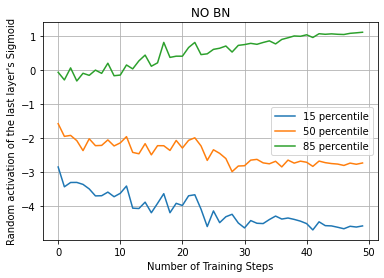

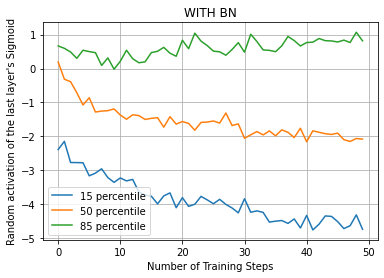

In [0]:
plot_percentile(activation_list, title='NO BN', save=True, fname='random_neuron_percentile_NO_BN')
plot_percentile(activation_list_BN,  title='WITH BN', save=True, fname='random_neuron_percentile_BN')

This is using np.percentile on all the last hidden layer:

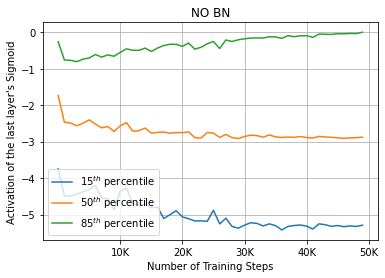

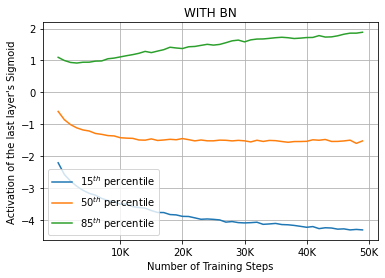

In [0]:
plot_mean_percentile(all_activations, title='NO BN', save=True, fname='percentile_ffn_NO_BN')
plot_mean_percentile(all_activations_BN, title='WITH BN', save=True, fname='percentile_ffn_BN')

In [0]:
plot_accuracy(accuracies, accuracies_BN, 'FFN', save=True, fname='fnn_accuracies')

...Training starts...
Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
)
[1,  1000] loss: 230.622
[2,  1000] loss: 230.493
[3,  1000] loss: 230.379
[4,  1000] loss: 230.123
[5,  1000] loss: 229.370
[6,  1000] loss: 218.181
[7,  1000] loss: 174.359
[8,  1000] loss: 135.111
[9,  1000] loss: 106.625
[10,  1000] loss: 85.777
[11,  1000] loss: 66.227
[12,  1000] loss: 56.895
[13,  1000] loss: 51.317
[14,  1000] loss: 47.238
[15,  1000] loss: 43.892
[16,  1000] loss: 41.104
[17,  1000] loss: 38.468
[18,  1000] loss: 36.118
[19,  1000] loss: 33.821
[20,  1000] loss: 31.730
[21,  1000] loss: 29.797
[22,  1000] loss: 27.910
[23,  1000] loss: 26.189
[24,  1000] loss: 24.588
[25,  1000] loss: 23.143
[26,  1000] loss: 21.871
[27,  1000] loss: 20.654
[28,  1000] los

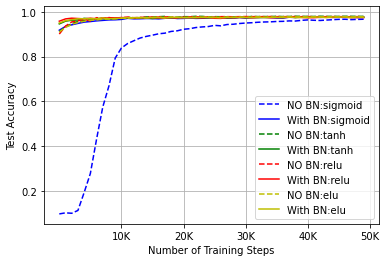

In [0]:
# Varing the activation function to see if the behaviour changes

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

color   = ['b', 'g', 'r', 'y']
activation_list = ['sigmoid', 'tanh', 'relu', 'elu']

for i, choice_activation in enumerate(activation_list):

  # initialize networks with choice of activation function
  net =       Net(lr=0.005, momentum=0.9, choice_activation=choice_activation)
  net_BN = Net_BN(lr=0.005, momentum=0.9, choice_activation=choice_activation)

  # train networks
  accuracies, activation_list, all_activations = train(net, trainloader, testloader, epochs = 50) 
  accuracies_BN, activation_list_BN, all_activations_BN = train(net_BN, trainloader, testloader, epochs = 50) 

  ax.plot(np.array(accuracies)/100,    color = color[i],  linestyle='--', label='NO BN:' + choice_activation) 
  ax.plot(np.array(accuracies_BN)/100, color = color[i], label='With BN:' + choice_activation) 


plt.xticks([10, 20, 30, 40, 50], ('10K', '20K', '30K', '40K', '50K'))
plt.xlabel('Number of Training Steps')
plt.ylabel('Test Accuracy')
plt.legend(loc='best')
plt.grid()
plt.savefig('Comparison_activations', dpi=200)
plt.show()

...Training starts...
Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
)
[1,  1000] loss: 230.628
[2,  1000] loss: 230.428
[3,  1000] loss: 230.345
[4,  1000] loss: 229.993
[5,  1000] loss: 229.086
[6,  1000] loss: 216.653
[7,  1000] loss: 155.986
[8,  1000] loss: 118.077
[9,  1000] loss: 81.914
[10,  1000] loss: 67.299
[11,  1000] loss: 59.601
[12,  1000] loss: 54.215
[13,  1000] loss: 49.990
[14,  1000] loss: 46.468
[15,  1000] loss: 43.274
[16,  1000] loss: 40.238
[17,  1000] loss: 37.416
[18,  1000] loss: 34.653
[19,  1000] loss: 32.105
[20,  1000] loss: 29.869
[21,  1000] loss: 27.787
[22,  1000] loss: 26.045
[23,  1000] loss: 24.506
[24,  1000] loss: 23.103
[25,  1000] loss: 21.909
[26,  1000] loss: 20.774
[27,  1000] loss: 19.729
[28,  1000] loss

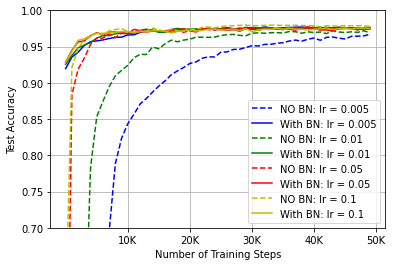

In [0]:
# Varing the learning rate to see differences in training time

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

color   = ['b', 'g', 'r', 'y']
lr_list = [0.005, 0.01, 0.05, 0.1]

for i, lr in enumerate(lr_list):

  # initialize networks with learning rate
  net = Net(lr=lr, momentum=0.9)
  net_BN = Net_BN(lr=lr, momentum=0.9)

  # train networks
  accuracies, activation_list, all_activations = train(net, trainloader, testloader, epochs = 50) 
  accuracies_BN, activation_list_BN, all_activations_BN = train(net_BN, trainloader, testloader, epochs = 50) 

  ax.plot(np.array(accuracies)/100, color = color[i],  linestyle='--', label=f'NO BN: lr = {lr}')
  ax.plot(np.array(accuracies_BN)/100, color = color[i], label=f'With BN: lr = {lr}')



plt.xticks([10, 20, 30, 40, 50], ('10K', '20K', '30K', '40K', '50K'))
plt.ylim([0.7, 1])
plt.xlabel('Number of Training Steps')
plt.ylabel('Test Accuracy')
plt.legend(loc='best')
plt.grid()
plt.savefig('Comparison_lrs_from_0_7', dpi=200)
plt.show()

In [0]:
break

In [0]:
# WITHOUT BATCH NORMALISATION
class Conv(nn.Module):
    def __init__(self, lr=0.001, momentum=0.9):
        super(Conv, self).__init__()
        # layers
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1) # 6 filters with size 3
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # hyperparameters
        self.lr = lr
        self.momentum = momentum

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=self.lr, momentum=self.momentum)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
        self.name = 'cnn_NO_BN'

    def forward(self, x):
        x = torch.Tensor(x).to(self.device)

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 7 * 7)
        x = F.relu(self.fc1(x))
  
        x = self.fc2(x) 
        self.activation = x[:,0] # (60,) 
        self.activations = x  # (60, 100)
        x = F.relu(x)
        
        x = self.fc3(x)
        return x

# WITH BATCH NORMALISATION
class Conv_BN(nn.Module):
    def __init__(self, lr=0.001, momentum=0.9):
        super(Conv_BN, self).__init__()
        # layers
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(6) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 7 * 7, 120)
        self.fc1_bn = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc2_bn = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)
        # hyperparameters
        self.lr = lr
        self.momentum = momentum

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=self.lr, momentum=self.momentum)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
        self.name = 'cnn_BN'

    def forward(self, x):
        x = torch.Tensor(x).to(self.device)
        
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))

        x = x.view(-1, 16 * 7 * 7)
        x = F.relu(self.fc1_bn(self.fc1(x)))

        x = self.fc2_bn(self.fc2(x))
        self.activation = x[:, 0]   # (60,)
        self.activations = x  # (60, 100)
        x = F.relu(x)

        x = self.fc3(x)
        return x


In [0]:
convnet_BN = Conv_BN(lr = 0.001, momentum = 0.9)
convnet = Conv(lr = 0.001, momentum = 0.9)

In [0]:
accuracies_cnn, activations_list_cnn, all_activations_cnn = train(convnet, trainloader, testloader, epochs = 30)

...Training starts...
Conv(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
)
[1,  1000] loss: 196.944
[2,  1000] loss: 37.531
[3,  1000] loss: 23.177
[4,  1000] loss: 17.040
[5,  1000] loss: 13.462
[6,  1000] loss: 11.419
[7,  1000] loss: 10.068
[8,  1000] loss: 8.985
[9,  1000] loss: 8.282
[10,  1000] loss: 7.610
[11,  1000] loss: 7.017
[12,  1000] loss: 6.600
[13,  1000] loss: 6.215
[14,  1000] loss: 5.866
[15,  1000] loss: 5.565
[16,  1000] loss: 5.239
[17,  1000] loss: 4.899
[18,  1000] loss: 4.743
[19,  1000] loss: 4.361
[20,  1000] loss: 4.298
[21,  1000] loss: 4.010
[22,  1000] lo

In [0]:
accuracies_cnn_BN, activations_list_cnn_BN, all_activations_cnn_BN = train(convnet_BN, trainloader, testloader, epochs = 30)

...Training starts...
Conv_BN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc1_bn): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc2_bn): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
)
[1,  1000] loss: 40.762
[2,  1000] loss: 10.578
[3,  1000] loss: 7.296
[4,  1000] loss: 5.775
[5,  1000] loss: 4.740
[6,  1000] loss: 4.128
[7

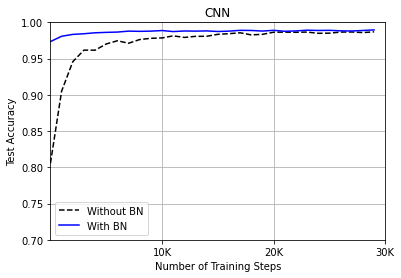

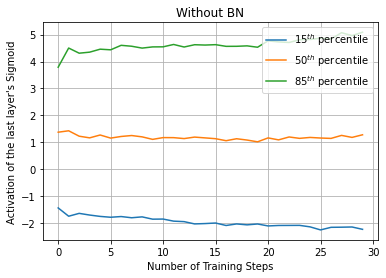

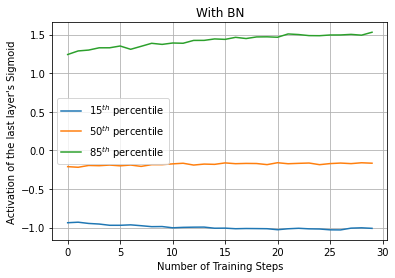

In [0]:
plot_accuracy(accuracies_cnn, accuracies_cnn_BN, epochs = 30, title='CNN', save=True, fname='cnn_accuracies') 
plot_mean_percentile(all_activations_cnn, title='Without BN', save=True, fname='percentile_cnn_NO_BN')
plot_mean_percentile(all_activations_cnn_BN, title='With BN', save=True, fname='percentile_cnn_BN')

In [0]:
break
# If we want to save the accuracies to txt

np.savetxt('accuracies.txt', accuracies)
np.savetxt('accuracies_BN.txt', accuracies_BN)
np.savetxt('accuracies_conv.txt', accuracies_cnn)
np.savetxt('accuracies_conv_BN.txt', accuracies_cnn_BN)